# 21M.387 Fundamentals of Music Processing
## Problem Set 7: Structure Analysis

Make sure all your answers and plots display when the code block is run. You can leave word-based answers in code comments or markdown cells.

You may use any fmplib functions from __previous__ units in your answers. You may __not__ use any fmplib functions from the current unit in your answers (unless explicitly noted). But you can use the current unit's fmplib for testing your code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['image.interpolation'] = 'nearest'

fmp.documentation_button()

## Exercise 1

The following are two sequences of song boundaries:

- `est` is an algorithmically generated estimate of song boundaries and is given as sample locations at a feature rate of $F_f = 10\text{Hz}$.
- `ref` is the ground truth / reference annotation, given in seconds.

In [2]:
est = np.load('data/ex1_est.npy')
ref = np.load('data/ex1_ref.npy')
ff = 10.

Write the function `comparison_plot(bounds1, bounds2)` that creates a plot of two sequences _on the same plot_. Find a good way of displaying this information so that both sequences are shown and are easy to visually compare (so you can eyeball which markers match and which do not). 

You can use `plt.vlines()`, `plt.plot()` with `ro`, or any other plotting function that works for you. Using colors can also be useful.

Of course, for the comparison to make sense, the inputs to comparison_plot must be in the same time scale.

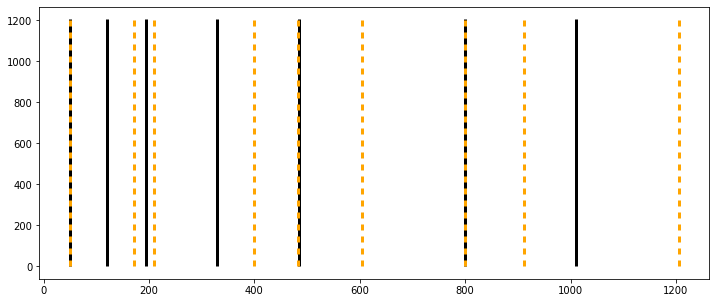

In [28]:
def comparison_plot(bounds1, bounds2):
    max_x = max(np.max(bounds1), np.max(bounds2))
    plt.vlines(bounds1, 0, max_x, 'black', label='bounds1', linewidth=3)
    plt.vlines(bounds2, 0, max_x, 'orange', label='bounds2', linewidth=3, linestyle=(0, (2, 2)))
    plt.show()

# call your function here...
ref_samples = np.array(ref * ff).astype(int)
comparison_plot(est, ref_samples)

## Exercise 2

Write the function `compare_boundaries(est, ref, tau)` with inputs:

- `est`: an `np.array` of estimated boundary locations
- `ref`: an `np.array` of the ground truth boundary locations
- `tau`: the distance metric used to determine a match

Return a tuple of three numbers:

- the number of True Positives
- the number of False Positives
- the number of False Negatives

When comparing an estimated point $b^{\text{Est}}$ and reference point $b^{\text{Ref}}$, consider
$$\vert b^{\text{Est}} - b^{\text{Ref}} \vert < \tau$$
as an indication of a match.

Caution: careful not to double count matches in cases where two estimates $b^{\text{Est}}_i$ and $b^{\text{Est}}_j$ are both close to the same $b^{\text{Ref}}$. In this case, one estimate should count as a True Positive, while the other as a False Positive.

In [160]:
def compare_boundaries(est, ref, tau):
    tp = []
    fp = []
    fn = []

    def is_match(x, y):
        return np.abs(x - y) <= tau
    
    tp_est = set()
    tp_ref = set()
    
    # can improve on n^2 by keeping track of last ref idx
    for e in est:
        for r in ref:
            if e not in tp_est and r not in tp_ref and is_match(e, r):
                # all matches count towards True Positive (#TP)
                tp_est.add(e)
                tp_ref.add(r)

    # all remaining est count towards False Positive (#FP)
    # all remaining ref count towards False Negative (#FN)                
    fp = set(est) - tp_est
    fn = set(ref) - tp_ref
    
    return (len(tp_est), len(fp), len(fn))

What are the True Positive, False Positive, and False Negative counts for the Exercise 1 estimate and reference sequences using $\tau = 1$ and $\tau = 3$ seconds?

Store your answers as tuples in the variables below

In [173]:
ex2_t1 = compare_boundaries(est, ref_samples, 1. * ff)
ex2_t3 = compare_boundaries(est, ref_samples, 3. * ff)
print(f'ex2_t1={ex2_t1}')
print(f'ex2_t3={ex2_t3}')

# print('\nfmplib:')
# est_tp, est_fp, ref_tp, ref_fn = fmp.pos_neg_split(est, ref_samples, 1. * ff)
# print(f'({len(est_tp)}, {len(est_fp)}, {len(ref_fn)})')
# est_tp, est_fp, ref_tp, ref_fn = fmp.pos_neg_split(est, ref_samples, 3. * ff)
# print(f'({len(est_tp)}, {len(est_fp)}, {len(ref_fn)})')

ex2_t1=(3, 4, 6)
ex2_t3=(4, 3, 5)


## Exercise 3

Write a function that returns the Precision, Recall, and F-Measure of two boundary sequences. This function can make use of the `compare_boundaries()` above.

Inputs: same as in Exercise 2.

Outputs:
A tuple of the calculated values for Precision, Recall, and F-measure

In [170]:
def calc_boundaries_PRF(est, ref, tau):
    tp, fp, fn = compare_boundaries(est, ref_samples, tau)
    
    p = tp / (float(tp) + float(fp))
    r = tp / (float(tp) + float(fn))
    f = 2.0 * p * r / (float(p) + float(r))
    
    return (p, r, f)

Print out the values of Precision, Recall, and F-measure for the above sequences using $\tau = 1$ and $\tau = 3$ seconds.

In [176]:
ex3_t1 = calc_boundaries_PRF(est, ref_samples, 1.0 * ff)
ex3_t3 = calc_boundaries_PRF(est, ref_samples, 3.0 * ff)
print(f'ex3_t1={ex3_t1}')
print(f'ex3_t3={ex3_t3}')

# print(fmp.calc_prf(est, ref_samples, 1. * ff))
# print(fmp.calc_prf(est, ref_samples, 3. * ff))

ex3_t1=(0.42857142857142855, 0.3333333333333333, 0.375)
ex3_t3=(0.5714285714285714, 0.4444444444444444, 0.5)


## Exercise 4a

In the next three Exercises, you will create the algorithm for section boundary detection using Structure Features.

- Load the audio below.
- Create $\mathbf{S}$, the self-similarity matrix using `audio_to_ssm()` with CENS parameters $l = 25$ and $d = 3$.
- Plot $\mathbf{S}$. 

In [177]:
snd = fmp.load_wav('audio/brahms_hungarian_dance_5a.wav')

In [178]:
def audio_to_ssm(snd, cens_filt_len, cens_ds):
    'Returns the SSM and its feature rate'
    fft_len = 4096
    hop_size = fft_len // 2
    chroma = fmp.make_chromagram(snd, 22050., fft_len, hop_size)
    chroma = fmp.cens(chroma, cens_filt_len, cens_ds)
    ff = 22050. / hop_size / cens_ds
    return np.dot(chroma.T, chroma), ff

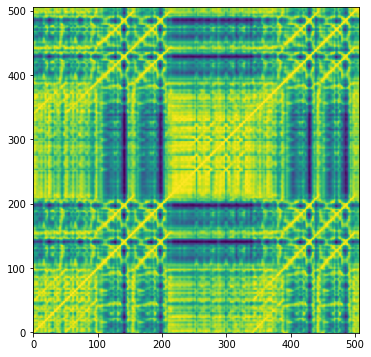

In [181]:
# create and plot the SSM:
cens_filt_len = 25
cens_ds = 3
ssm, ff = audio_to_ssm(snd, cens_filt_len, cens_ds)

plt.figure(figsize=(10,6))
plt.imshow(ssm, origin='lower');

Create $\mathbf{S}_D$ by applying diagonal smoothing to $\mathbf{S}$ to enhance the diagonal lines of the matrix.

- Use `fmp.diagonal_smoothing(m, win_len)` with a window length of 5 seconds. Note that the function expects `win_len` ($L_D$) to be in units of samples, not seconds.
- Plot $\mathbf{S}_D$.

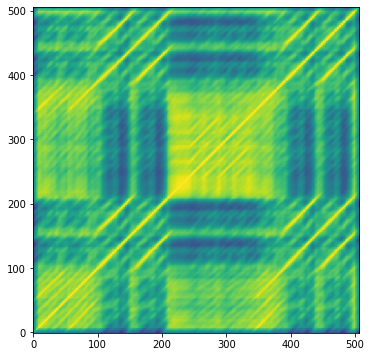

In [187]:
# create and plot S_D
win_len = int(5. * ff)
ssm_d = fmp.diagonal_smoothing(ssm, win_len)

plt.figure(figsize=(10,6))
plt.imshow(ssm_d, origin='lower');

## Exercise 4b

Following the text's explanation of thresholding, starting on page 192, write the function `threshold_and_scale()` as follows:

Inputs:
- `ssm`: $\mathbf{S}$, a self-similarity matrix
- `tau`: $\tau$, the threshold value

Output:
- The resulting SSM

Notes:
- Assume $\mathbf{S}[n,m] \in [0, 1]$.
- Apply a threshold. For every value of $\mathbf{S}[n,m]$, set $\mathbf{S}_{\tau}[n,m] = 0$ if $\mathbf{S}[n,m] < \tau$. 
- Apply a scaling such that values in the range $[\tau, 1]$ of $\mathbf{S}_{\tau}$ are linearly scaled to the range $[0, 1]$ and all other values $(< \tau)$, are set to $0$.

In [355]:
def threshold_and_scale(ssm, tau):
    m = np.copy(ssm)
    
    # scale first -> values less than tau will be negative
    m = (m - tau) / (np.max(ssm) - tau)  # assuming np.max(ssm) is 1.0
    m[m < 0] = 0
    
    return m

To test your function:
- Create $\mathbf{S}_{\tau}$ from $\mathbf{S}_D$ with $\tau = 0.85$.
- Plot $\mathbf{S}_{\tau}$ 

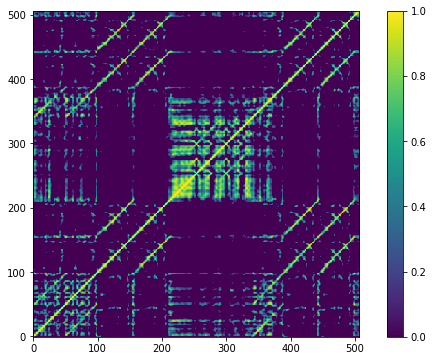

In [356]:
tau = .85
ssm_t = threshold_and_scale(ssm, tau)

plt.figure(figsize=(10,6))
plt.imshow(ssm_t, origin='lower');
plt.colorbar();

## Exercise 5

Convert the enhanced SSM into a structure features matrix as follows:

Write the function `create_lag_matrix()` which creates a circular lag matrix

Inputs:
- `ssm`: $\mathbf{S}$, a self-similarity matrix

Output:
- The resulting circular lag matrix, $\mathbf{L^{\circ}}$

As described on page 213 of the text:
$$\mathbf{L^{\circ}}[l,n] = \mathbf{S}[(n+l) \text{ mod } N, n]$$

While this notation may be a bit confusing, the diagrams help clarify this operation.

In [357]:
def create_lag_matrix(ssm):
    L = np.zeros(ssm.shape)
    N = L.shape[0]
    
    for l in range(N):
        for n in range(N):
            L[l,n] = ssm[(n+l)%N,n]
    
    return L

To test,
- Create $\mathbf{L}^{\circ}$ from $\mathbf{S}_{\tau}$
- Plot $\mathbf{L}^{\circ}$

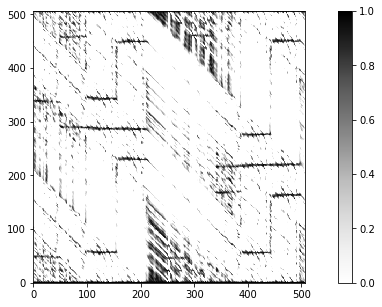

In [358]:
lag = create_lag_matrix(ssm_t)
plt.imshow(lag2, origin='lower', cmap='Greys')
plt.colorbar()
plt.show()

# lag2 = fmp.make_lag_matrix(ssm_t)
# plt.imshow(lag2, origin='lower', cmap='Greys')
# plt.colorbar()
# plt.show()

## Exercise 6a

The final step is to create a boundaries novelty curve by applying a derivative function to $\mathbf{L}^{\circ}$.

- Create an $M \times L_K$ derivative kernel $\mathbf{K}_{\Delta}$ using `fmp.make_derivative_kernel(rows, k_len)`. Set $M$ to be the number of rows of $\mathbf{S}$ and $L_K$ to be the equivalent of 20 seconds. As before $L_K$ is in units of samples, not seconds.
- Plot $\mathbf{K}_{\Delta}$
- Plot a single row of $\mathbf{K}_{\Delta}$ to better see the profile of this matrix. Any row is fine since all rows are the same.

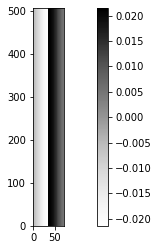

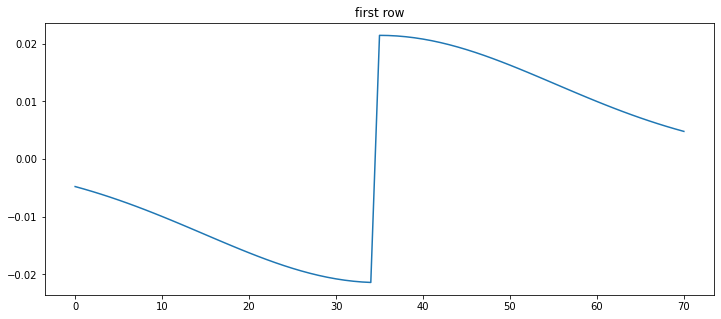

In [359]:
ck_len = int(20. * ff)
rows = ssm_t.shape[0]
ck = fmp.make_derivative_kernel(rows, ck_len)

plt.figure(figsize = (12,4))
plt.imshow(ck, origin='lower', cmap='Greys');
plt.colorbar();
plt.show()

plt.plot(ck[0,:])
plt.title('first row')
plt.show()

## Exercise 6b

As outlined in the lecture notes, use $\mathbf{K}_{\Delta}$ to create $\Delta_S[n]$:

- Slide $\mathbf{K}_{\Delta}$ horizontally along $\mathbf{L^{\circ}}$. At each time step $n$:
    - Compute $\mathbf{D}^{[n]} = \mathbf{K}_{\Delta}^{[n]} \odot \mathbf{L^{\circ}}$, where $\mathbf{K}_{\Delta}^{[n]}$ is the kernel centered at $n$, and $\odot$ means element-wise multiplication.
    - Sum the rows to produce a column vector $l_{\Delta}^{[n]} = \sum_j \mathbf{D}^{[n]}[m,j]$ 
    - The magnitude ($L_2$ norm) of $l_{\Delta}^{[n]}$ represents the likelihood of a structural boundary at $n$.

- $\Delta_S[n] = \Vert l_{\Delta}^{[n]} \Vert$ is the __structure novelty function__.

Write the function `column_derivative(lag_matrix, k_len)` which produces $\Delta_S[n]$.

Inputs:

- `lag_matrix`: $\mathbf{L^{\circ}}$
- `k_len`: $L_K$, the length of the derivative kernel.

Outputs:

- $\Delta_S[n]$, which should be the same length as the number of columns in the input matrix.

You should use `fmp.make_derivative_kernel()` that you tested in Exercise 6a.

In [360]:
def column_derivative(lag_matrix, k_len):
    ck = fmp.make_derivative_kernel(lag_matrix.shape[0], ck_len)
    
    n_cols = lag_matrix.shape[1]
    nov = np.zeros(n_cols)
    
    lag = np.hstack([np.zeros(ck.shape), lag_matrix, np.zeros(ck.shape)])  # padding
    k = np.zeros(lag_matrix.shape)
    k = np.hstack([np.zeros(ck.shape), k, np.zeros(ck.shape)])  # padding
    for n in range(n_cols):
        d = k_len // 2 + 1
        l = np.sum(ck * lag[:, n+d:n+d+k_len], axis=1)
        nov[n] = np.linalg.norm(l, ord=2)

    return nov

Finally, test your function using $\mathbf{L^{\circ}}$ and $L_K$ from above (setting `nov_s`) and plot the resulting curve.

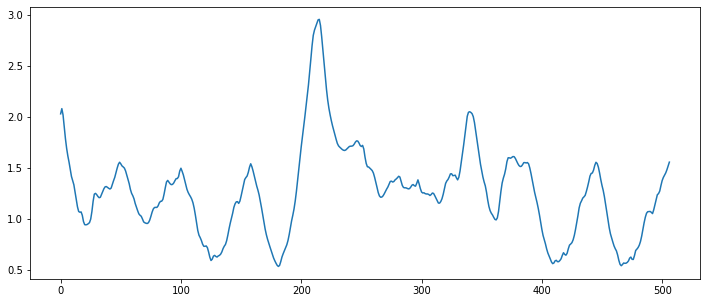

In [362]:
nov_s = column_derivative(lag, ck_len)
plt.plot(nov_s);
plt.show()

# fmplib
# nov = fmp.column_derivative(lag, ck_len)
# plt.plot(nov);
# plt.show()

## Exercise 6c

The boundary location estimates are the peaks of this novelty curve. 

Use `fmp.find_region_peaks(x, region_len)` to locate the peaks with a region length of 6 seconds. This function returns the highest peak in a neighborhood of $L_R$ samples. Set the result to  `est`.



In [ ]:
est = ...

## Exercise 7

This boundary detection algorithm has a number of parameters which must be tuned. One way of tuning parameters is to test a large variety of different parameters against a known ground truth set.

In the following three exercises, you will create a system for optimizing some of the parameters of the structure features boundary detection algorithm using some of _The Beatles_ ground truth set.

Create the function `song_boundary_score()`:

Inputs:
- `ssm`: $\mathbf{S}$, the regular SSM of the song
- `ff`: $F_f$, the sampling rate of $\mathbf{S}$
- `ref`: the reference annotations
- `diag_len`: $L_D$, diagonal smooth length for creating $\mathbf{S}_D$
- `ssm_tau`: $\tau$, the thresholding parameter for creating $\mathbf{S}_{\tau}$
- `k_len`: $L_K$, derivative kernel length used for creating $\mathbf{K}_{\Delta}$
- `region_len`: $L_R$, region length for finding peaks in $\Delta_S[n]$

Output: 
- the F-measure score of the estimated boundaries versus the reference annotations.

Additional Notes:
- Combine the elements of Exercises 4-6 to create the full algorithm in one function.
- If you are worried that your solutions above might be off, you can use the `fmplib` versions of the functions.
- Use $\tau = 3$ seconds for the F-measure calculation (sorry, different parameter with the same Greek letter).

In [ ]:
def song_boundary_score(ssm, ff, ref, diag_len, ssm_tau, k_len, region_len):
    pass


Run this function with the files below, creating $\mathbf{S}$ using `audio_to_ssm()` with CENS parameters $l = 25$ and $d = 3$.

Use parameters: $L_D = 10$, $\tau = 0.8$, $L_K = 80$, $L_R = 40$. You should get a score of about $0.47$.

In [ ]:
wav_file = "beatles/beatles_oh_darling.wav"
ref_file = "beatles/beatles_oh_darling.lab"

ex7_score = ...

## Exercise 8

It is important to test on a large number of songs to get confidence in our parameter choices. First, gather the songs by writing the function `create_dataset()`. This represents the fixed data that does not change throughout the testing.

Input:
- `dir_path`: the directory path to search for audio and reference files.

Output:
- a list of tuples, one per song, where each tuple is `(ssm, ff, ref)` for that song using CENS parameters $l = 25$ and $d = 3$.

The following python functions may be handy: `os.listdir`, `os.path.join`.

Create the dataset for the directory `"beatles"`. This directory contains only 4 songs, but you can imagine working with a larger dataset.

In [ ]:
import os
def create_dataset(dir_path):
    pass

dataset = ...

Next, write the function `average_boundary_score()` that computes the average F-measure for all songs in the dataset for a given set of parameters.

Inputs:
- `dataset`: the dataset of songs
- `diag_len`: $L_D$, diagonal smooth length for creating $\mathbf{S}_D$
- `ssm_tau`: $\tau$, the thresholding parameter for creating $\mathbf{S}_{\tau}$
- `k_len`: $L_K$, derivative kernel length used for creating $\mathbf{K}_{\Delta}$
- `region_len`: $L_R$, region length for finding peaks in $\Delta_S[n]$

Output:
- the average F-measure boundary score across all the data in dataset using the given parameters.

Use `song_boundary_score()` that you already wrote.

In [ ]:
def average_boundary_score(dataset, diag_len, ssm_tau, k_len, region_len):
    pass

Find the average boundary score using the Beatles dataset and the same parameters as in Exercise 7. 

In [ ]:
ex8_score = ...

## Exercise 9

The last step is to find a reasonably good parameter set that maximizes the average F-measure for the whole dataset. This problem is more open-ended. You should create the dataset once, and then repeatedly call `average_boundary_score` with different parameter sets, searching for the highest scoring set. 

It is useful to think about good operating bounds for these parameters. For example:
- $L_D$: should probably be in the range $2-10$ seconds (but remember to convert to samples) 
- $\tau$: $.5 - .95$
- $L_K$: $10-50$ seconds
- $L_R$: $10-30$ seconds 


You can use whatever search method you'd like. A good starting point is a grid-based search where you iterate through a finite set of parameter combinations, spaced over a 4-dimensional grid. You can try a rough initial search (with a course grid) to find a maxima, followed by a finer-grained search to hone in on the highest value in that neighborhood.

Print the highest scoring parameters and the resulting F-measure. Keep all your code and experiments so we can see how you found your values.


In [ ]:
ex9_score = ...
ex9_params = ...